##### Project 2 - Big-Scale Analytics 
##### Team ROLEX - Samuel Lew, Alexandre Lang, Samy Bouzerda, Alix Muller
-------
# Kaggle: Real or Not? NLP with Disaster Tweets
-------

# 0. Kaggle competition

> In this competition, people have to create machine learning models to predict whether the tweets test set mention a disaster or not. This challenge is a binary classification problem.

This competition's Dataset shows a set of tweets divided into a training and a test set. The training set has a column named 'target' that permits to identify if the tweet contains an infomation about a disaster or not.

For example, here are one tweet about a disaster and another not:

In [4]:
import pandas as pd

train = pd.read_csv('../data/train.csv')
train = train.sample(frac=1, replace=False)
train = train[['id', 'keyword', 'location', 'text', 'target']]

# A disaster tweet
disaster_tweet = train[train['target'] == 1]['text']
disaster_tweet.values[1]

'3 Former Executives to Be Prosecuted in Fukushima Nuclear Disaster http://t.co/JSsmMLNaQ7'

In [5]:
# A tweet not concerning a disaster
non_disaster_tweet = train[train['target'] == 0]['text']
non_disaster_tweet.values[1]

'@hazelannmac ooh now I feel guilty about wishing hatman out. I bet the mudslide was delicious!'

# I. Libraries

Let's first import the libraries that we will need during this analysis.

In [6]:
import pandas as pd
import seaborn as sns
import seaborn as sns; sns.set()

import matplotlib.pyplot as plt
import numpy as np

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import re

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from wordcloud import WordCloud
from string import punctuation

# II. EDA
Before starting the classification problems, we have to explore the dataset. 
During this exploratory analysis, we will observe the distribution of data according the differents variables available: Target, Keyword, Location and Text. 

It permits to understand better the composition of the dataset, and undertand more about the tweets we will have to classify.

In [7]:
train = pd.read_csv('../data/train.csv')
train = train.sample(frac=1, replace=False)
train = train[['id', 'keyword', 'location', 'text', 'target']]
train.head(10)

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
7180,10289,weapon,"BROOKLYN, NYC",Please allow me to reiterate it's not the weap...,1
4034,5729,forest%20fire,NaN,5:15p For those who watch over me forest fire ...,1
7033,10079,typhoon,NaN,nbanews Soudelor Typhoon Soudelor is taking de...,1
5007,7141,military,highlands&slands scotland,Bad News for US: China Russia Bolstering Milit...,0
5990,8555,screams,NaN,I come downstairs trying to look as normal as ...,0
343,492,armageddon,Nowhere. Everywhere.,@RohnertParkDPS You're on stage now! Right und...,0
5982,8542,screams,lesa * she/her,@TromboneTristan OOOOOHSHIT OOOHSHIT SCREAMS h...,0
7130,10213,volcano,NaN,Maailiss: Diaporama : sixpenceee: Karymsky Lak...,0
3250,4671,engulfed,NaN,Men escape car engulfed in flames in Parley's ...,1


### Distribution Target
This binary variable, like explained earlier, permits to identify the tweets mentionning a disaster from a tweet mentionning something else.
The following code permit to know the number of tweets in the train dataset, and to identify the repartition of disaster tweets.

In [8]:
total_count = 0
for row in train.iterrows():
  total_count += 1
print(f'There are {total_count} tweets in the dataset')

train_yes = train.query('target == 1')
yes_count = 0
for row in train_yes.iterrows():
    yes_count += 1
print(f'There are {yes_count} tweets about disasters')

train_no = train.query('target == 0')
no_count = 0
for row in train_no.iterrows():
    no_count += 1
print(f'There are {no_count} tweets that are not about disasters')

print('The classification base rate is ' + str(yes_count/(yes_count+no_count)*100)[:5] + '%')

There are 7613 tweets in the dataset
There are 3271 tweets about disasters
There are 4342 tweets that are not about disasters
The classification base rate is 42.96%


Text(0, 0.5, 'Samples')

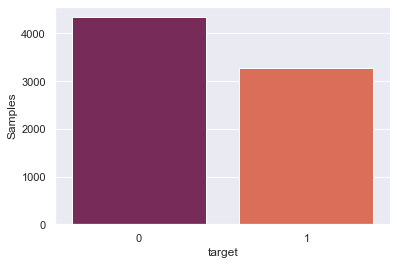

In [9]:
sns.countplot('target',data = train, palette = 'rocket')
plt.gca().set_ylabel('Samples')

### Most common keywords
This column recapitulates the keyword representing the tweet's text. The following barplot shows the most frequent keywords in the train dataset.

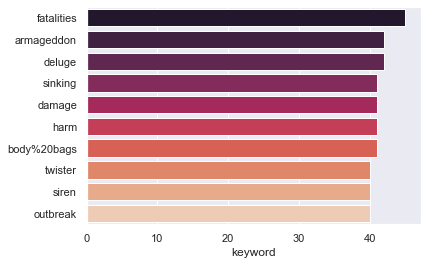

In [10]:
sns.barplot(y = train['keyword'].value_counts()[:10].index, x = train['keyword'].value_counts()[:10], orient='h', palette = 'rocket')

### Most common locations

Each tweet has been written from some location. In the following plot, we can find the top 15 locations of this tweet's dataset. 

We can notice that already different words have been used for the same country: USA and United States. So these two columns should have been counted together. Also, some shows the country, others the city or even state. 
This is why this graph is quantitatively not reprentative, and that later on we will process the text in order to correct text errors.

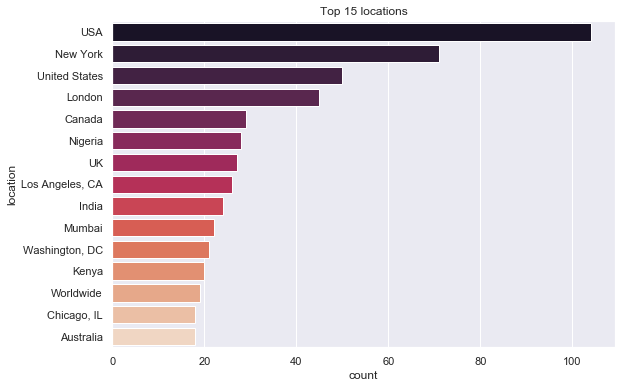

In [11]:
plt.figure(figsize=(9,6))
sns.countplot(y=train.location, order = train.location.value_counts().iloc[:15].index, palette = 'rocket')
plt.title('Top 15 locations')
plt.show()

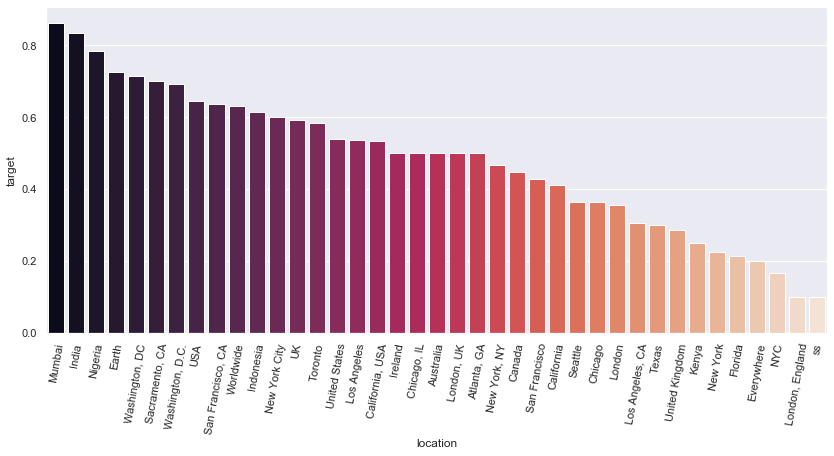

In [12]:
raw_loc = train.location.value_counts()
top_loc = list(raw_loc[raw_loc>=10].index)
top_only = train[train.location.isin(top_loc)]

top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l.index, y=top_l, palette = 'rocket')
plt.xticks(rotation=80)
plt.show()

### Distribution of Character, Word and Sentence Frequency

Then, in order to undertand the lenght of the tweet texts, we created these graphs. They are displaying the number of characters, the number of words and the number of sentences of each tweet, and separating the disaster tweets from the non-disaster tweets. 

There is more outliers in disaster tweets than in non-disaster tweets.

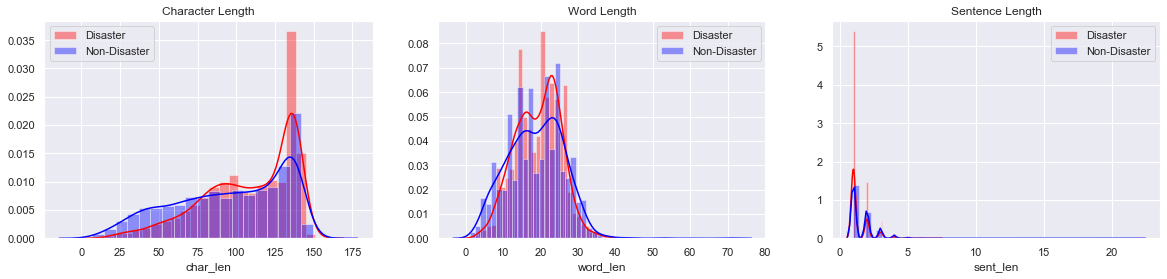

In [13]:
# count number of characters in each tweet
train['char_len'] = train.text.str.len()

# count number of words in each tweet
word_tokens = [len(word_tokenize(tweet)) for tweet in train.text]
train['word_len'] = word_tokens

# count number of sentence in each tweet
sent_tokens = [len(sent_tokenize(tweet)) for tweet in train.text]
train['sent_len'] = sent_tokens

plot_cols = ['char_len','word_len','sent_len']
plot_titles = ['Character Length','Word Length','Sentence Length']

plt.figure(figsize=(20,4))
for counter, i in enumerate([0,1,2]):
    plt.subplot(1,3,counter+1)
    sns.distplot(train[train.target == 1][plot_cols[i]], label='Disaster', color='red').set_title(plot_titles[i])
    sns.distplot(train[train.target == 0][plot_cols[i]], label='Non-Disaster', color='blue')
    plt.legend()

### Most common stopwords

The stopwords used are overall the same for disaster tweets than for non-disaster tweets. However, the stopword 'the' apprears significately more frequently than in non-disaster tweets, and also the use of 'I' that appears 3 times more in the tweet's text. 

As there are 3271 tweets about disasters compared to 4342 tweets that are not about disasters (overall less tweets on disasters) it is interesting to notice that personal/possessive pronouns as 'I', 'you' and 'my' are more used when people tweets about disasters.

Text(0.5, 1.0, 'Top Stopwords for  Non-Disaster Tweets')

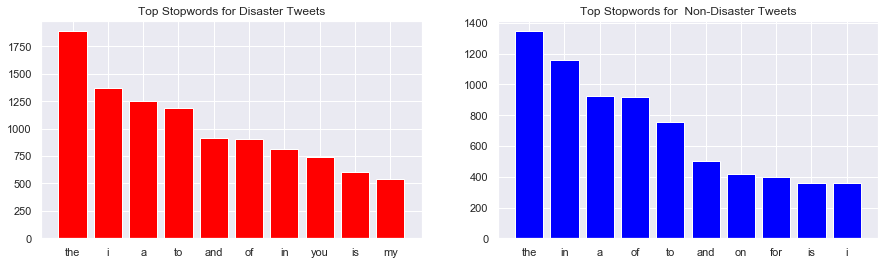

In [14]:
## Plot most common stopwords

stop = set(stopwords.words('english'))

# Get all the word tokens in dataframe for Disaster and Non-Disaster
corpus0 = [] # Non-Disaster
[corpus0.append(word.lower()) for tweet in train[train.target == 0].text for word in word_tokenize(tweet)]
corpus1 = [] # Disaster
[corpus1.append(word.lower()) for tweet in train[train.target == 1].text for word in word_tokenize(tweet)]

# Function for counting top stopwords in a corpus
def count_top_stopwords(corpus):
    stopwords_freq = {}
    for word in corpus:
        if word in stop: 
            if word in stopwords_freq:
                stopwords_freq[word] += 1
            else:
                stopwords_freq[word] = 1
    topwords = sorted(stopwords_freq.items(), key=lambda item: item[1], reverse=True)[:10] # get the top 10 stopwords
    x,y = zip(*topwords) # get key and values
    return x,y

x0,y0 = count_top_stopwords(corpus0)
x1,y1 = count_top_stopwords(corpus1)

# Plot bar plot of top stopwords for each class
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.bar(x0,y0, color='red')
plt.title('Top Stopwords for Disaster Tweets')
plt.subplot(1,2,2)
plt.bar(x1,y1, color='blue')
plt.title('Top Stopwords for  Non-Disaster Tweets')

### Most common punctuations
In this section, we plotted the most common ponctuations that are used in the tweets, comparing the disaster tweet and non-disaster tweet again. There is not much of a trend to underline from these graphs, apart from the fact that people seems to use more punctuation when they tweet about disaster, and also using more question marks '?'.

Text(0.5, 1.0, 'Top Punctuations for Non-Disaster Tweets')

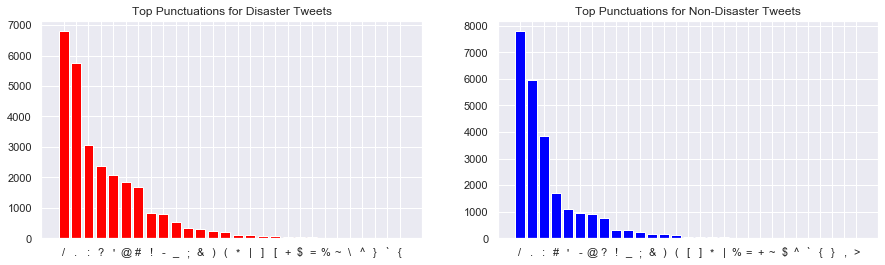

In [15]:
## Plot most common punctuations

# Get all the punctuations in dataframe for Disaster and Non-Disaster
corpus0 = [] # Non-Disaster
[corpus0.append(c) for tweet in train[train.target == 0].text for c in tweet]
corpus0 = list(filter(lambda x: x in punctuation, corpus0)) # use filter to select only punctuations
corpus1 = [] # Disaster
[corpus1.append(c) for tweet in train[train.target == 1].text for c in tweet]
corpus1 = list(filter(lambda x: x in punctuation, corpus1)) 

from collections import Counter
x0,y0 = zip(*Counter(corpus0).most_common())
x1,y1 = zip(*Counter(corpus1).most_common())

# Plot bar plot of top punctuations for each class
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.bar(x0,y0, color='red')
plt.title('Top Punctuations for Disaster Tweets')
plt.subplot(1,2,2)
plt.bar(x1,y1, color='blue')
plt.title('Top Punctuations for Non-Disaster Tweets')

### Most common words

What are the differences in terms of words used for these tweets?

For disasters, people use certain words such as: news, disaster, suicide, killed, police etc.

While for non-disasters, like, I, body, video, etc come out more frequently.

The word 'like'appears more than two times more in non-disaster tweets than in disaster one, while 'people'is mentionned as many times. If we give a look at the word cloud, the classification between the non-disaster tweets from the disaster ones seems quite good, so the 'target'column looks globally efficient, even if not fully precise.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

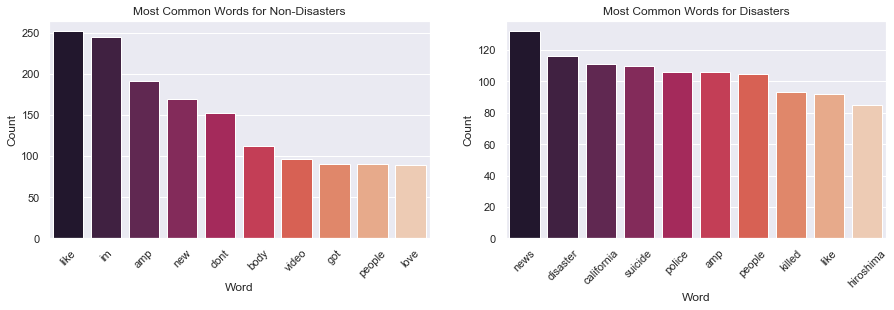

In [16]:
## Plot most common words

stop = ENGLISH_STOP_WORDS.union(stop) # combine stop words from different sources

# function for removing url from text
def remove_url(txt):
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

# Get all the word tokens in dataframe for Disaster and Non-Disaster
# - remove url, tokenize tweet into words, lowercase words
corpus0 = [] # Non-Disaster
[corpus0.append(word.lower()) for tweet in train[train.target == 0].text for word in word_tokenize(remove_url(tweet))]
corpus0 = list(filter(lambda x: x not in stop, corpus0)) # use filter to unselect stopwords

corpus1 = [] # Disaster
[corpus1.append(word.lower()) for tweet in train[train.target == 1].text for word in word_tokenize(remove_url(tweet))]
corpus1 = list(filter(lambda x: x not in stop, corpus1)) # use filter to unselect stopwords

# Create df for word counts to use sns plots
a = Counter(corpus0).most_common()
df0 = pd.DataFrame(a, columns=['Word','Count'])

a = Counter(corpus1).most_common()
df1 = pd.DataFrame(a, columns=['Word','Count'])

# Plot for Disaster and Non-Disaster
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.barplot(x='Word',y='Count', palette = 'rocket', data=df0.head(10)).set_title('Most Common Words for Non-Disasters')
plt.xticks(rotation=45)
plt.subplot(1,2,2)
sns.barplot(x='Word',y='Count', palette = 'rocket', data=df1.head(10)).set_title('Most Common Words for Disasters')
plt.xticks(rotation=45)

Text(0.5, 1.0, 'Disaster')

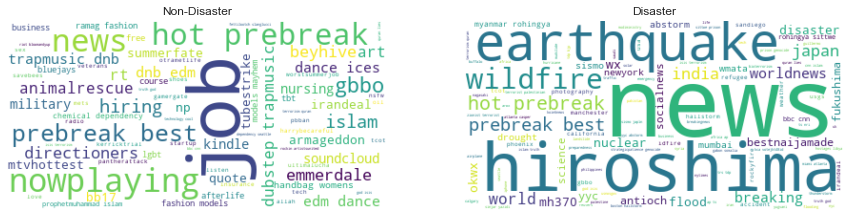

In [17]:
def clean(word):
    for p in punctuation: word = word.replace(p, '')
    return word

def wc_hash(target):
    hashtag = [clean(w[1:].lower()) for tweet in train[train.target == target].text for w in tweet.split() if '#' in w and w[0] == '#']
    hashtag = ' '.join(hashtag)
    my_cloud = WordCloud(background_color='white', stopwords=stop).generate(hashtag)

    plt.subplot(1,2,target+1)
    plt.imshow(my_cloud, interpolation='bilinear') 
    plt.axis("off")

plt.figure(figsize=(15,4))
wc_hash(0)
plt.title('Non-Disaster')
wc_hash(1)
plt.title('Disaster')

# III. Data processing
In order to build the classification models, we need to preprocess the data. As we will work on text, we have to homogenize the sentences and words by lowercasing the words, remove the punctuation and stopwords, but also tokenize the tweets and in the end reacreate the sentences.

## 1. Import libraries and load data

In [18]:
import pandas as pd
import string
import spacy
import re
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from nltk.corpus import stopwords
import nltk

parser = English()
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
punctuations = string.punctuation

In [19]:
train = pd.read_csv ('../data/train.csv')
train = train[['id', 'text', 'target']]

test = pd.read_csv ('../data/test.csv')
test = test[['id', 'text']]

train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


## 2. Text processing

### Lowercase and remove punctuation

In [20]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text
  
  
train['filtered_tweet'] = train['text'].apply(lambda x: clean_text(x))
test['filtered_tweet'] = test['text'].apply(lambda x: clean_text(x))

train.head()

,id,text,target,filtered_tweet
0,1,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


### Tokenize tweets

In [21]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

train['filtered_tweet'] = train['filtered_tweet'].apply(lambda x: tokenizer.tokenize(x))

test['filtered_tweet'] = test['filtered_tweet'].apply(lambda x: tokenizer.tokenize(x))

train.head()

,id,text,target,filtered_tweet
0,1,Our Deeds are the Reason of this #earthquake M...,1,"[our, deeds, are, the, reason, of, this, earth..."
1,4,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]"
2,5,All residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, shelter, in, place..."
3,6,"13,000 people receive #wildfires evacuation or...",1,"[people, receive, wildfires, evacuation, order..."
4,7,Just got sent this photo from Ruby #Alaska as ...,1,"[just, got, sent, this, photo, from, ruby, ala..."


### Remove stopwords and punctuation

In [22]:
# remove stopwords and punctuation
def remove_stopwords(text):
    text = [word for word in text if word not in stopwords.words('english')]
    text = [word for word in text if word not in punctuations]
    
    return text

train['filtered_tweet'] = train['filtered_tweet'].apply(lambda x: remove_stopwords(x))

test['filtered_tweet'] = test['filtered_tweet'].apply(lambda x: remove_stopwords(x))

train.head()

,id,text,target,filtered_tweet
0,1,Our Deeds are the Reason of this #earthquake M...,1,"[deeds, reason, earthquake, may, allah, forgiv..."
1,4,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]"
2,5,All residents asked to 'shelter in place' are ...,1,"[residents, asked, shelter, place, notified, o..."
3,6,"13,000 people receive #wildfires evacuation or...",1,"[people, receive, wildfires, evacuation, order..."
4,7,Just got sent this photo from Ruby #Alaska as ...,1,"[got, sent, photo, ruby, alaska, smoke, wildfi..."


### Recreate sentences

In [23]:
def sentence(text):
  sentence = ''
  for word in text:
    sentence = sentence + ' ' + word
  
  return sentence

train['filtered_tweet'] = train['filtered_tweet'].apply(lambda x: sentence(x))

test['filtered_tweet'] = test['filtered_tweet'].apply(lambda x: sentence(x))

train.head()

,id,text,target,filtered_tweet
0,1,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified office...
3,6,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders ca...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires po...


# IV. Classification models

## Content
0. Create pipe
1. KNN
2. Multinomial Naive Bayes
3. Bernoulli Naive Bayes
4. Logistic Regression
5. Neural Networks
6. Decision Tree Classifier
7. Random Forest Classifier
8. Decision Tree Regressor
9. Support Vector Machines

## 0. Create pipe

In [24]:
#!python -m spacy download en_core_web_sm

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import string
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [109]:
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() 
                if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens 
                if word not in stop_words and word not in punctuations ]

    return mytokens


X = train['filtered_tweet']
y = train['target']

tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

## 1. KNN

In [110]:
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72)

classifier = KNeighborsClassifier(n_neighbors = 3, weights = 'uniform')

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

accuracy = metrics.accuracy_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted, average=None)
recall = metrics.recall_score(y_test, predicted, average=None)

print(accuracy)

0.760507880910683


### Plot for different values of n

Text(0.5, 0.98, 'Accuracy, precision and recall for multiple value of n')

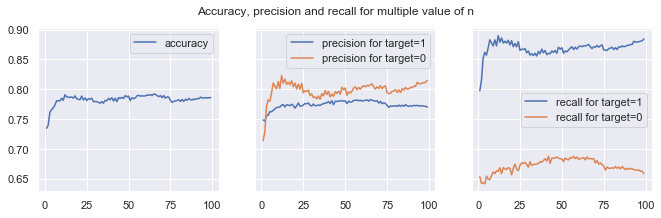

In [111]:
import numpy as np
import matplotlib.pyplot as plt


data_acc = {}
data_prec = {}
data_rec = {}


for i in range(1, 100, 1):
    classifier = KNeighborsClassifier(n_neighbors = i, weights = 'distance')

    pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

    pipe.fit(X_train, y_train)

    predicted = pipe.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, predicted)
    precision = metrics.precision_score(y_test, predicted, average=None)
    recall = metrics.recall_score(y_test, predicted, average=None)

    data_acc[i] = accuracy
    data_prec[i] = precision
    data_rec[i] = recall


names_acc = list(data_acc.keys())
values_acc = list(data_acc.values())

names_prec = list(data_prec.keys())
values_prec = list(data_prec.values())

names_rec = list(data_rec.keys())
values_rec = list(data_rec.values())

fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharey=True)

axs[0].plot(names_acc, values_acc, label='accuracy')
axs[0].legend()

axs[1].plot(names_prec, values_prec, label='precision')
axs[1].legend(('precision for target=1', 'precision for target=0'))

axs[2].plot(names_rec, values_rec, label='recall')
axs[2].legend(('recall for target=1', 'recall for target=0'))

fig.suptitle('Accuracy, precision and recall for multiple value of n')

In [28]:
print('optimal number of neighbors: ', np.argmax(values_acc))

classifier = KNeighborsClassifier(n_neighbors = np.argmax(values_acc), weights = 'distance')

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

accuracy = metrics.accuracy_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted, average=None)
recall = metrics.recall_score(y_test, predicted, average=None)

print('associated accuracy: ', accuracy)

optimal number of neighbors:  64
associated accuracy:  0.7894045534150613


### Plot for different values of train/test split treshold

Text(0.5, 0.98, 'Accuracy, precision and recall for multiple value of train/test split treshold')

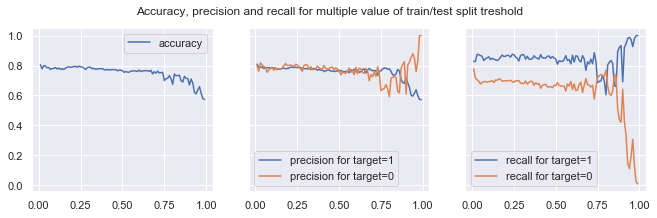

In [29]:
data_acc = {}
data_prec = {}
data_rec = {}


for i in range(1, 100, 1):
    j = i/100
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=j, random_state=72)
    
    classifier = KNeighborsClassifier(n_neighbors = 64, weights = 'distance')

    pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

    pipe.fit(X_train, y_train)

    predicted = pipe.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, predicted)
    precision = metrics.precision_score(y_test, predicted, average=None)
    recall = metrics.recall_score(y_test, predicted, average=None)

    data_acc[j] = accuracy
    data_prec[j] = precision
    data_rec[j] = recall


names_acc = list(data_acc.keys())
values_acc = list(data_acc.values())

names_prec = list(data_prec.keys())
values_prec = list(data_prec.values())

names_rec = list(data_rec.keys())
values_rec = list(data_rec.values())

fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharey=True)

axs[0].plot(names_acc, values_acc, label='accuracy')
axs[0].legend()

axs[1].plot(names_prec, values_prec, label='precision')
axs[1].legend(('precision for target=1', 'precision for target=0'))

axs[2].plot(names_rec, values_rec, label='recall')
axs[2].legend(('recall for target=1', 'recall for target=0'))

fig.suptitle('Accuracy, precision and recall for multiple value of train/test split treshold')

In [30]:
print('optimal treshold: ', np.argmax(values_acc))

optimal treshold:  0


In [31]:
# as the optimal treshold is 0 (overfitting), we'll take a treshold of 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

classifier = KNeighborsClassifier(n_neighbors = 64, weights = 'distance')

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

accuracy = metrics.accuracy_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted, average=None)
recall = metrics.recall_score(y_test, predicted, average=None)

print('associated accuracy: ', accuracy)

associated accuracy:  0.7898883782009193


### Run on test dataset

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001, random_state=72)

X_test = test['filtered_tweet']

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

test['prediction'] = predicted

test[['text', 'prediction']].head()

,text,prediction
0,Just happened a terrible car crash,1
1,"Heard about #earthquake is different cities, s...",1
2,"there is a forest fire at spot pond, geese are...",1
3,Apocalypse lighting. #Spokane #wildfires,0
4,Typhoon Soudelor kills 28 in China and Taiwan,1


#### Create submission file

In [33]:
sample_sub=pd.read_csv('../data/sample_submission.csv')

sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target': predicted})
sub.to_csv('../data/submission_KNN.csv',index=False)

## 2. Multinomial Naive Bayes

In [34]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

classifier = MultinomialNB()

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

accuracy = metrics.accuracy_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted, average=None)
recall = metrics.recall_score(y_test, predicted, average=None)

print(accuracy)

0.8010505581089954


### Plot for different values of train/test split treshold

Text(0.5, 0.98, 'Accuracy, precision and recall for multiple value of train/test split treshold')

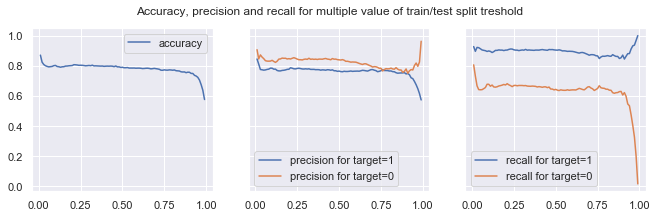

In [35]:
data_acc = {}
data_prec = {}
data_rec = {}


for i in range(1, 100, 1):
    j = i/100
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=j, random_state=72)

    classifier = MultinomialNB()
    
    pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

    pipe.fit(X_train, y_train)

    predicted = pipe.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, predicted)
    precision = metrics.precision_score(y_test, predicted, average=None)
    recall = metrics.recall_score(y_test, predicted, average=None)

    data_acc[j] = accuracy
    data_prec[j] = precision
    data_rec[j] = recall


names_acc = list(data_acc.keys())
values_acc = list(data_acc.values())

names_prec = list(data_prec.keys())
values_prec = list(data_prec.values())

names_rec = list(data_rec.keys())
values_rec = list(data_rec.values())

fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharey=True)

axs[0].plot(names_acc, values_acc, label='accuracy')
axs[0].legend()

axs[1].plot(names_prec, values_prec, label='precision')
axs[1].legend(('precision for target=1', 'precision for target=0'))

axs[2].plot(names_rec, values_rec, label='recall')
axs[2].legend(('recall for target=1', 'recall for target=0'))

fig.suptitle('Accuracy, precision and recall for multiple value of train/test split treshold')

In [36]:
print('optimal treshold: ', np.argmax(values_acc))

optimal treshold:  0


In [37]:
# as the optimal treshold is 0 (overfitting), we'll take a treshold of 0.2, which seems also to be an optimum

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

classifier = MultinomialNB()

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

accuracy = metrics.accuracy_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted, average=None)
recall = metrics.recall_score(y_test, predicted, average=None)

print('associated accuracy: ', accuracy)

associated accuracy:  0.8010505581089954


### Run on test dataset

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001, random_state=72)

X_test = test['filtered_tweet']

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

test['prediction'] = predicted

test[['text', 'prediction']].head()

,text,prediction
0,Just happened a terrible car crash,1
1,"Heard about #earthquake is different cities, s...",1
2,"there is a forest fire at spot pond, geese are...",1
3,Apocalypse lighting. #Spokane #wildfires,1
4,Typhoon Soudelor kills 28 in China and Taiwan,1


### Create submission file

In [39]:
sample_sub=pd.read_csv('../data/sample_submission.csv')

sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target': predicted})
sub.to_csv('../data/submission_MNB.csv',index=False)

## 3. Bernouilli Naive Bayes

In [40]:
from sklearn.naive_bayes import BernoulliNB

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

classifier = BernoulliNB()

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

accuracy = metrics.accuracy_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted, average=None)
recall = metrics.recall_score(y_test, predicted, average=None)

print(accuracy)

0.8036769533814839


### Plot for different values of train/test split treshold

Text(0.5, 0.98, 'Accuracy, precision and recall for multiple value of train/test split treshold')

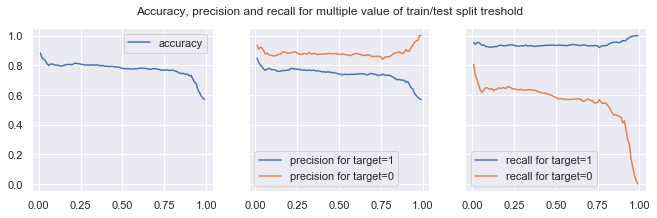

In [41]:
data_acc = {}
data_prec = {}
data_rec = {}


for i in range(1, 100, 1):
    j = i/100
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=j, random_state=72)

    classifier = BernoulliNB()
    
    pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

    pipe.fit(X_train, y_train)

    predicted = pipe.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, predicted)
    precision = metrics.precision_score(y_test, predicted, average=None)
    recall = metrics.recall_score(y_test, predicted, average=None)

    data_acc[j] = accuracy
    data_prec[j] = precision
    data_rec[j] = recall


names_acc = list(data_acc.keys())
values_acc = list(data_acc.values())

names_prec = list(data_prec.keys())
values_prec = list(data_prec.values())

names_rec = list(data_rec.keys())
values_rec = list(data_rec.values())

fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharey=True)

axs[0].plot(names_acc, values_acc, label='accuracy')
axs[0].legend()

axs[1].plot(names_prec, values_prec, label='precision')
axs[1].legend(('precision for target=1', 'precision for target=0'))

axs[2].plot(names_rec, values_rec, label='recall')
axs[2].legend(('recall for target=1', 'recall for target=0'))

fig.suptitle('Accuracy, precision and recall for multiple value of train/test split treshold')

In [42]:
print('optimal treshold: ', np.argmax(values_acc))

optimal treshold:  0


In [43]:
# as the optimal treshold is 0 (overfitting), we'll take a treshold of 0.2, which seems also to be an optimum

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

classifier = BernoulliNB()

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

accuracy = metrics.accuracy_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted, average=None)
recall = metrics.recall_score(y_test, predicted, average=None)

print('associated accuracy: ', accuracy)

associated accuracy:  0.8036769533814839


### Run on test dataset

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

X_test = test['filtered_tweet']

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

test['prediction'] = predicted

test[['text', 'prediction']].head()

,text,prediction
0,Just happened a terrible car crash,1
1,"Heard about #earthquake is different cities, s...",1
2,"there is a forest fire at spot pond, geese are...",1
3,Apocalypse lighting. #Spokane #wildfires,0
4,Typhoon Soudelor kills 28 in China and Taiwan,1


### Create submission file

In [45]:
sample_sub=pd.read_csv('../data/sample_submission.csv')

sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target': predicted})
sub.to_csv('../data/submission_BNB.csv',index=False)

## 4. Logistic regression

In [81]:
from sklearn.linear_model import LogisticRegression

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=72)

classifier = LogisticRegression(solver="lbfgs")

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

accuracy = metrics.accuracy_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted, average=None)
recall = metrics.recall_score(y_test, predicted, average=None)

print(accuracy)

0.8114495798319328


In [48]:
print(f'For a train/test split treshold of 0.3: \n')

print(f'We can see here that our model identified a tweet about a disaster {str(accuracy*100)[:4]}% of the time. \n')

print(f'When it predicted a tweet to be about a disaster, it was correctly assessed {str(precision[0]*100)[:4]}% of the time, \nand was correctly assessed for a tweet not about a disaster {str(precision[1]*100)[:4]}% of the time. \n')

print(f'When given a tweet about a disaster, the model considered it as being about a disaster {str(recall[0]*100)[:4]}% of the time, \nand when given a tweet not about a disaster the model considered it as not a disaster for {str(recall[1]*100)[:4]}% of the time. \n')

For a train/test split treshold of 0.3: 

We can see here that our model identified a tweet about a disaster 80.6% of the time. 

When it predicted a tweet to be about a disaster, it was correctly assessed 77.9% of the time, 
and was correctly assessed for a tweet not about a disaster 86.1% of the time. 

When given a tweet about a disaster, the model considered it as being about a disaster 91.7% of the time, 
and when given a tweet not about a disaster the model considered it as not a disaster for 66.3% of the time. 



### Plot the results for different levels of train/test split treshold

/Users/Samuel/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0.5, 0.98, 'Accuracy, precision and recall for multiple value of train/test split treshold')

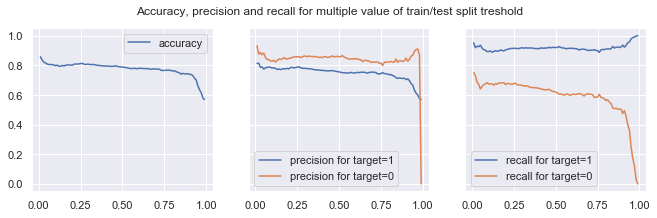

In [49]:
import matplotlib.pyplot as plt

X = train['filtered_tweet']
y = train['target']

data_acc = {}
data_prec = {}
data_rec = {}


for i in range(1, 100, 1):
  j = i/100
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=j, random_state=72)
  
  pipe.fit(X_train, y_train)

  predicted = pipe.predict(X_test)

  accuracy = metrics.accuracy_score(y_test, predicted)
  precision = metrics.precision_score(y_test, predicted, average=None)
  recall = metrics.recall_score(y_test, predicted, average=None)
  
  data_acc[j] = accuracy
  data_prec[j] = precision
  data_rec[j] = recall
  
names_acc = list(data_acc.keys())
values_acc = list(data_acc.values())

names_prec = list(data_prec.keys())
values_prec = list(data_prec.values())

names_rec = list(data_rec.keys())
values_rec = list(data_rec.values())

fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharey=True)

axs[0].plot(names_acc, values_acc, label='accuracy')
axs[0].legend()

axs[1].plot(names_prec, values_prec, label='precision')
axs[1].legend(('precision for target=1', 'precision for target=0'))

axs[2].plot(names_rec, values_rec, label='recall')
axs[2].legend(('recall for target=1', 'recall for target=0'))

fig.suptitle('Accuracy, precision and recall for multiple value of train/test split treshold')

In [50]:
print('From those graphs, we can see that the optimal train/test split treshold is: ', np.argmax(values_acc))

From those graphs, we can see that the optimal train/test split treshold is:  0


### Test the model on the testing dataset

In [95]:
# taking a very small split treshold leads to overfitting; let's take 0.25 as it looks like a good optimum

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=72)

X_test = test['filtered_tweet']

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

test['prediction'] = predicted

test[['text', 'prediction']].head()

,text,prediction
0,Just happened a terrible car crash,1
1,"Heard about #earthquake is different cities, s...",1
2,"there is a forest fire at spot pond, geese are...",1
3,Apocalypse lighting. #Spokane #wildfires,0
4,Typhoon Soudelor kills 28 in China and Taiwan,1


### Create submission file

In [96]:
sample_sub=pd.read_csv('../data/sample_submission.csv')

sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target': predicted})
sub.to_csv('../data/submission_LR.csv',index=False)

## 5. Neural networks

### Vectorizing tweets

In [53]:
from sklearn.feature_extraction.text import CountVectorizer

X_train = train['filtered_tweet']
y_train = train['target']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

word_vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b", 
                stop_words=None, ngram_range=(2,2), analyzer='word')

# Vectorize the training set
X_train = word_vectorizer.fit_transform(X_train.map(lambda words: ', '.join(words)))

print('train input shape: ', X_train.shape)

train input shape:  (7613, 867)


### Building the model

In [54]:
#!pip install -U protobuf==3.8.0

In [55]:
#!pip install --upgrade tensorflow

In [56]:
#!pip install keras

In [57]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils

Using TensorFlow backend.


In [58]:
model = Sequential()
model.add(Dense(X_train.shape[0], input_shape=(X_train.shape[1],), use_bias=False))
model.add(Activation('relu')) # An "activation" is just a non-linear function applied to the output
                              # of the layer above. Here, with a "rectified linear unit",
                              # we clamp all values below 0 to 0.

model.add(Dropout(0.2))# Dropout helps protect the model from memorizing or "overfitting" the training data
#model.add(Dense(X_train.shape[0], input_shape=(X_train.shape[1],), use_bias=False, activation='sigmoid'))
#model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [59]:
#optimizer = keras.optimizers.Adam(lr=0.01, decay=1e-6)

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=True, name="SGD")
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 7613)              6600471   
_________________________________________________________________
activation_1 (Activation)    (None, 7613)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7613)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7614      
Total params: 6,608,085
Trainable params: 6,608,085
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [61]:
model_hist = model.fit(X_train, y_train,
                       batch_size=100, epochs=50,
                       verbose=1, validation_split=0.2)

Train on 6090 samples, validate on 1523 samples
Epoch 1/50
6090/6090 [==============================] - 4s 692us/step - loss: 0.6811 - accuracy: 0.5839 - val_loss: 0.6788 - val_accuracy: 0.5811
Epoch 2/50
6090/6090 [==============================] - 4s 621us/step - loss: 0.6590 - accuracy: 0.6437 - val_loss: 0.6671 - val_accuracy: 0.6028
Epoch 3/50
6090/6090 [==============================] - 4s 633us/step - loss: 0.6424 - accuracy: 0.6726 - val_loss: 0.6532 - val_accuracy: 0.6415
Epoch 4/50
6090/6090 [==============================] - 4s 612us/step - loss: 0.6275 - accuracy: 0.6985 - val_loss: 0.6429 - val_accuracy: 0.6586
Epoch 5/50
6090/6090 [==============================] - 4s 629us/step - loss: 0.6167 - accuracy: 0.7103 - val_loss: 0.6368 - val_accuracy: 0.6678
Epoch 6/50
6090/6090 [==============================] - 4s 618us/step - loss: 0.6045 - accuracy: 0.7161 - val_loss: 0.6351 - val_accuracy: 0.6566
Epoch 7/50
6090/6090 [==============================] - 4s 621us/step - loss

### Evaluate performance

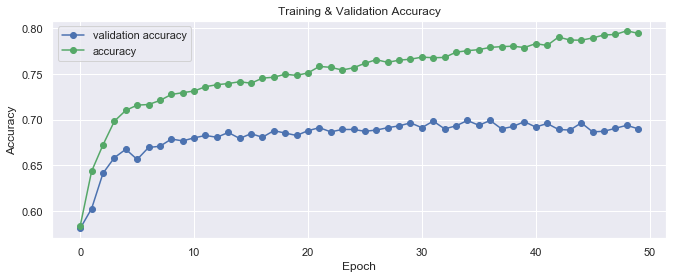

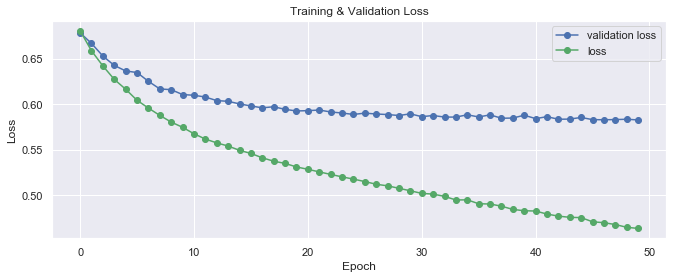

In [62]:
fig, plt_acc = plt.subplots(1, 1, figsize=(11, 4), sharey=True)
plt_acc.plot(model_hist.history['val_accuracy'], 'b-o', label='validation accuracy')
plt_acc.plot(model_hist.history['accuracy'], 'g-o', label='accuracy')
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

fig, plt_loss = plt.subplots(1, 1, figsize=(11, 4), sharey=True)
plt_loss.plot(model_hist.history['val_loss'], 'b-o', label='validation loss')
plt_loss.plot(model_hist.history['loss'], 'g-o', label='loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

### Run on test dataset

In [63]:
X_test = test['filtered_tweet']
X_test = word_vectorizer.transform(X_test.map(lambda words: ', '.join(words)))

predicted = model.predict_classes(X_test)

test['prediction'] = predicted

test[['text', 'prediction']].head()

,text,prediction
0,Just happened a terrible car crash,0
1,"Heard about #earthquake is different cities, s...",0
2,"there is a forest fire at spot pond, geese are...",0
3,Apocalypse lighting. #Spokane #wildfires,1
4,Typhoon Soudelor kills 28 in China and Taiwan,0


In [64]:
predicted = np.concatenate(predicted)
predicted.shape

(3263,)

In [65]:
sample_sub=pd.read_csv('../data/sample_submission.csv')

sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target': predicted})
sub.to_csv('../data/submission_NN.csv',index=False)

## 6. Decision trees

### Load data

In [66]:
X = train['filtered_tweet']
y = train['target']

### Fit the model

In [67]:
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

classifier = DecisionTreeClassifier(criterion='entropy')

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])
    
pipe.fit(X_train, y_train)

pipe.score(X_test, y_test)

0.7485226526592252

In [68]:
classifier.get_depth()

488

### Plot for different values of depth

The optimal depth is:  92


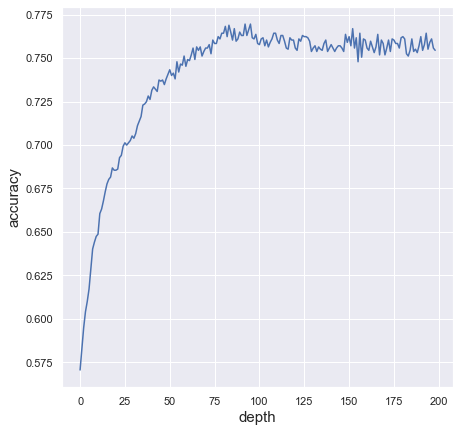

In [69]:
scores = []
for d in range(1, 200):
    classifier = DecisionTreeClassifier(criterion='gini', max_depth=d)
    
    pipe = Pipeline([('vectorizer', tfidf_vector), ('classifier', classifier)])
    
    pipe.fit(X_train, y_train)
    
    scores.append(pipe.score(X_test, y_test))
    
    
plt.plot(scores)
plt.ylabel('accuracy', fontsize=15)
plt.xlabel('depth', fontsize=15)

print('The optimal depth is: ', np.argmax(scores))

### Plot for different values of train/test split treshold

Text(0.5, 0.98, 'Accuracy, precision and recall for multiple value of train/test split treshold')

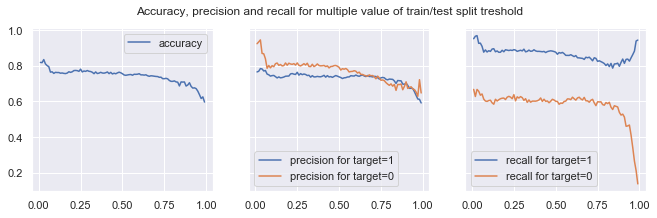

In [70]:
import matplotlib.pyplot as plt

X = train['filtered_tweet']
y = train['target']

data_acc = {}
data_prec = {}
data_rec = {}


for i in range(1, 100, 1):
  j = i/100
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=j, random_state=72)
  
  classifier = DecisionTreeClassifier(criterion='gini', max_depth=np.argmax(scores))

  pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])
    
  pipe.fit(X_train, y_train)

  predicted = pipe.predict(X_test)

  accuracy = metrics.accuracy_score(y_test, predicted)
  precision = metrics.precision_score(y_test, predicted, average=None)
  recall = metrics.recall_score(y_test, predicted, average=None)
  
  data_acc[j] = accuracy
  data_prec[j] = precision
  data_rec[j] = recall
  
names_acc = list(data_acc.keys())
values_acc = list(data_acc.values())

names_prec = list(data_prec.keys())
values_prec = list(data_prec.values())

names_rec = list(data_rec.keys())
values_rec = list(data_rec.values())

fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharey=True)

axs[0].plot(names_acc, values_acc, label='accuracy')
axs[0].legend()

axs[1].plot(names_prec, values_prec, label='precision')
axs[1].legend(('precision for target=1', 'precision for target=0'))

axs[2].plot(names_rec, values_rec, label='recall')
axs[2].legend(('recall for target=1', 'recall for target=0'))

fig.suptitle('Accuracy, precision and recall for multiple value of train/test split treshold')

### Evaluate model

In [104]:
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=72)

classifier = DecisionTreeClassifier(criterion='gini', max_depth=np.argmax(scores))

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])
    
pipe.fit(X_train, y_train)

pipe.score(X_test, y_test)

y_pred = pipe.predict(X_train)

print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))
print(pipe.score(X_test, y_test))

[[4248    8]
 [ 964 2240]]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4256
           1       1.00      0.70      0.82      3204

    accuracy                           0.87      7460
   macro avg       0.91      0.85      0.86      7460
weighted avg       0.89      0.87      0.86      7460

0.8300653594771242


### Run on test dataset

In [100]:
X_test = test['filtered_tweet']

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

test['prediction'] = predicted

test[['text', 'prediction']].head()

,text,prediction
0,Just happened a terrible car crash,0
1,"Heard about #earthquake is different cities, s...",1
2,"there is a forest fire at spot pond, geese are...",1
3,Apocalypse lighting. #Spokane #wildfires,0
4,Typhoon Soudelor kills 28 in China and Taiwan,1


### Create submission file

In [101]:
sample_sub=pd.read_csv('../data/sample_submission.csv')

sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target': predicted})
sub.to_csv('../data/submission_DT.csv',index=False)

## 7. Random Forest Classifier

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, confusion_matrix

X = train['filtered_tweet']
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

classifier = RandomForestClassifier(criterion='gini', random_state=0)

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])
    
pipe.fit(X_train, y_train)

pipe.score(X_test, y_test)

y_pred = pipe.predict(X_train)

print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

/Users/Samuel/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[3462   31]
 [ 179 2418]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3493
           1       0.99      0.93      0.96      2597

    accuracy                           0.97      6090
   macro avg       0.97      0.96      0.96      6090
weighted avg       0.97      0.97      0.97      6090



### Plot for different values of train/test split treshold

/Users/Samuel/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Samuel/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Samuel/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Samuel/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Samuel/anaconda3/lib/python3.7/si

/Users/Samuel/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Samuel/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Samuel/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Samuel/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Samuel/anaconda3/lib/python3.7/si

/Users/Samuel/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Samuel/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Samuel/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Samuel/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Samuel/anaconda3/lib/python3.7/si

Text(0.5, 0.98, 'Accuracy, precision and recall for multiple value of train/test split treshold')

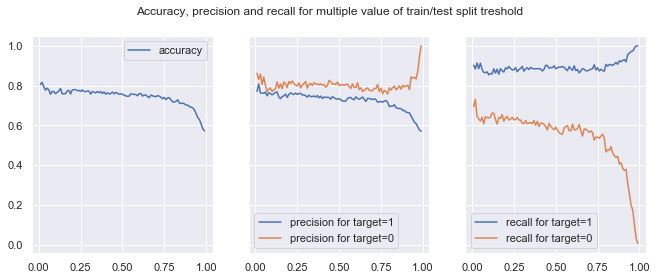

In [75]:
import matplotlib.pyplot as plt

X = train['filtered_tweet']
y = train['target']

data_acc = {}
data_prec = {}
data_rec = {}


for i in range(1, 100, 1):
  j = i/100
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=j, random_state=72)
  
  classifier = RandomForestClassifier(criterion='gini', random_state=0)

  pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])
    
  pipe.fit(X_train, y_train)

  predicted = pipe.predict(X_test)

  accuracy = metrics.accuracy_score(y_test, predicted)
  precision = metrics.precision_score(y_test, predicted, average=None)
  recall = metrics.recall_score(y_test, predicted, average=None)
  
  data_acc[j] = accuracy
  data_prec[j] = precision
  data_rec[j] = recall
  
names_acc = list(data_acc.keys())
values_acc = list(data_acc.values())

names_prec = list(data_prec.keys())
values_prec = list(data_prec.values())

names_rec = list(data_rec.keys())
values_rec = list(data_rec.values())

fig, axs = plt.subplots(1, 3, figsize=(11, 4), sharey=True)

axs[0].plot(names_acc, values_acc, label='accuracy')
axs[0].legend()

axs[1].plot(names_prec, values_prec, label='precision')
axs[1].legend(('precision for target=1', 'precision for target=0'))

axs[2].plot(names_rec, values_rec, label='recall')
axs[2].legend(('recall for target=1', 'recall for target=0'))

fig.suptitle('Accuracy, precision and recall for multiple value of train/test split treshold')

### Evaluate model

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, confusion_matrix

X = train['filtered_tweet']
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

classifier = RandomForestClassifier(criterion='gini', random_state=0)

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])
    
pipe.fit(X_train, y_train)

pipe.score(X_test, y_test)

y_pred = pipe.predict(X_train)

print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

/Users/Samuel/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[3462   31]
 [ 179 2418]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3493
           1       0.99      0.93      0.96      2597

    accuracy                           0.97      6090
   macro avg       0.97      0.96      0.96      6090
weighted avg       0.97      0.97      0.97      6090



### Run on test dataset

In [77]:
X_test = test['filtered_tweet']

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

test['prediction'] = predicted

test[['text', 'prediction']].head()

,text,prediction
0,Just happened a terrible car crash,1
1,"Heard about #earthquake is different cities, s...",1
2,"there is a forest fire at spot pond, geese are...",1
3,Apocalypse lighting. #Spokane #wildfires,0
4,Typhoon Soudelor kills 28 in China and Taiwan,1


### Create submission file

In [78]:
sample_sub=pd.read_csv('../data/sample_submission.csv')

sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target': predicted})
sub.to_csv('../data/submission_RFC.csv',index=False)

## 8. Decision Tree Regressor

### Split train/test data

In [79]:
X = train['filtered_tweet']
y = train['target']

### Fit the model

In [80]:
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

regressor = DecisionTreeRegressor(random_state=0)

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', regressor)])
    
pipe.fit(X_train, y_train)

pipe.score(X_test, y_test)
# this value is the coefficient of determination R^2

NameError: name 'DecisionTreeRegressor' is not defined

### Plot for different values of depth

In [ ]:
scores = []
for d in range(1, 200):
    regressor = DecisionTreeRegressor(random_state=0, max_depth=d)
    
    pipe = Pipeline([('vectorizer', tfidf_vector), ('classifier', regressor)])
    
    pipe.fit(X_train, y_train)
    
    scores.append(pipe.score(X_test, y_test))
    
    
plt.plot(scores)
plt.ylabel('R^2', fontsize=15)
plt.xlabel('depth', fontsize=15)

print('The optimal depth is: ', np.argmax(scores))

### Plot for different values of train/test split treshold

In [ ]:
import matplotlib.pyplot as plt

X = train['filtered_tweet']
y = train['target']

scores = {}

for i in range(1, 100, 1):
  j = i/100
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=j, random_state=72)
  
  regressor = DecisionTreeRegressor(random_state=0, max_depth=19)

  pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', regressor)])
    
  pipe.fit(X_train, y_train)

  predicted = pipe.predict(X_test)

  scores[j] = pipe.score(X_test, y_test)

  
names_r_squared = list(scores.keys())
values_r_squared = list(scores.values())

fig, axs = plt.subplots(1, 1, figsize=(11, 3), sharey=True)

axs.plot(names_acc, values_acc, label='R^2')
axs.legend()


fig.suptitle('R^2 for multiple value of train/test split treshold')

### Evaluate model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=72)

regressor = DecisionTreeRegressor(random_state=0, max_depth=19)

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', regressor)])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X)

pipe.score(X_test, y_test)

### Run on test dataset

In [ ]:
X_test = test['filtered_tweet']

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

test['prediction'] = predicted

test[['text', 'prediction']].head()

### Create submission file

In [ ]:
sample_sub=pd.read_csv('../data/sample_submission.csv')

sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target': predicted})
sub.to_csv('../data/submission_DTR.csv',index=False)

## 9. Support Vector Machine

In [ ]:
X = train['filtered_tweet']
y = train['target']

### Run the model

In [ ]:
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

classifier = svm.NuSVC(gamma='auto')

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])
    
pipe.fit(X_train, y_train)

pipe.score(X_test, y_test)

### Plot for different values of train/test split treshold

In [ ]:
import matplotlib.pyplot as plt

X = train['filtered_tweet']
y = train['target']

data_acc = {}
data_prec = {}
data_rec = {}


for i in range(1, 100, 1):
  j = i/100
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=j, random_state=72)
  
  classifier = svm.NuSVC(gamma='auto')

  pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])
    
  pipe.fit(X_train, y_train)

  predicted = pipe.predict(X_test)

  accuracy = metrics.accuracy_score(y_test, predicted)
  precision = metrics.precision_score(y_test, predicted, average=None)
  recall = metrics.recall_score(y_test, predicted, average=None)
  
  data_acc[j] = accuracy
  data_prec[j] = precision
  data_rec[j] = recall
  
names_acc = list(data_acc.keys())
values_acc = list(data_acc.values())

names_prec = list(data_prec.keys())
values_prec = list(data_prec.values())

names_rec = list(data_rec.keys())
values_rec = list(data_rec.values())

fig, axs = plt.subplots(1, 3, figsize=(11, 4), sharey=True)

axs[0].plot(names_acc, values_acc, label='accuracy')
axs[0].legend()

axs[1].plot(names_prec, values_prec, label='precision')
axs[1].legend(('precision for target=1', 'precision for target=0'))

axs[2].plot(names_rec, values_rec, label='recall')
axs[2].legend(('recall for target=1', 'recall for target=0'))

fig.suptitle('Accuracy, precision and recall for multiple value of train/test split treshold')

In [ ]:
print('0.02 seems to be a good treshold')

In [ ]:
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02)

classifier = svm.NuSVC(gamma='auto')

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])
    
pipe.fit(X_train, y_train)

pipe.score(X_test, y_test)

### Run on test dataset

In [ ]:
X_test = test['filtered_tweet']

pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

test['prediction'] = predicted

test[['text', 'prediction']].head()

### Create submission file

In [ ]:
sample_sub=pd.read_csv('../data/sample_submission.csv')

sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target': predicted})
sub.to_csv('../data/submission_SVM.csv',index=False)

# V. Conclusion on the results